# AutoKeras
StructuredDataBlock for preprocessing

Pass 1: Straight to RegressionHead

Pass 2: Dense Block

RegressionHead for final prediction

Pass 3: RNN (not) - StructuredDataRegressor single shot

Pass 4: SDB -> RH with custom loss

Pass 5: SDB -> DB -> RH with custom loss

Pass 6: SDR with custom loss

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import autokeras as ak

In [10]:
import keras.backend as K

In [45]:
import sklearn.metrics

In [46]:
# mean version of gross error metric
def weight_mse(truth,predict,**kwargs):
    erf = 0.0
    weight = [0.2, 20, 2, 3]
    for col in range(4):
        erf += sklearn.metrics.mean_squared_error(truth[:,col],predict[:,col],**kwargs) / (weight[col]**2)
    return erf

In [3]:
mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

In [4]:
print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")

Loading into numpy arrays...
Done with numpy loads


In [5]:
# partition data into a training and testing set using a random partition

# number of M(t) curves
N_data = np.shape(M)[0]

# pick a 90%/10% split for training/testing
test_frac = 0.10 # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data) # random ordering for all curves

train_idx = order_seed[0:div_idx] # first 90% of random order
test_idx = order_seed[div_idx:N_data] # last 10% of random order

# truncate time points to 210, 410
# !!! NOTE: May want to use all of the curve, takes longer to train though !!!
time_keep = range(0,450); # centered roughly at the echo

# concatenate the real and imaginary parts together, to make a real-vector of double the length
M_train = M[train_idx[:,None],time_keep]  # time truncation of input
mat_train = mat_info[train_idx,:]; # get the output
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part

# same as above, but for test
M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
M_test = np.hstack((np.real(M_test), np.imag(M_test)))

## Pass 1: Simple

In [24]:
input_node = ak.StructuredDataInput(name='M')
normed_node = ak.StructuredDataBlock()(input_node)
output_node = ak.RegressionHead()(normed_node)

pass1model = ak.AutoModel(inputs=input_node,outputs=output_node,
                          overwrite=False,max_trials=10)

INFO:tensorflow:Reloading Oracle from existing project ./auto_model/oracle.json
INFO:tensorflow:Reloading Tuner from ./auto_model/tuner0.json


In [25]:
# Feed the AutoModel with training data.
pass1model.fit(M_train, mat_train, epochs=10)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the bas

In [26]:
# Predict with the best model.
mat_tr_pred = pass1model.predict(M_train)
mat_test_pred = pass1model.predict(M_test)

In [10]:
# Evaluate the best model with testing data.
# this pass was max_trials=3, epochs=3
print("Training score for pass 1:",weight_mse(mat_train,mat_tr_pred))
print('Test score for pass 1:',weight_mse(mat_test,mat_test_pred))

Training score for pass 1: 0.26750121506203844
Test score for pass 1: 0.27397634423938805


In [20]:
# Evaluate the best model with testing data.
# this pass was max_trials=10, epochs=3
print("Training score for pass 1:",weight_mse(mat_train,mat_tr_pred))
print('Test score for pass 1:',weight_mse(mat_test,mat_test_pred))

Training score for pass 1: 0.28927788964675033
Test score for pass 1: 0.2965243776861328


In [27]:
# Evaluate the best model with testing data.
# this pass was max_trials=10, epochs=10
print("Training score for pass 1:",weight_mse(mat_train,mat_tr_pred))
print('Test score for pass 1:',weight_mse(mat_test,mat_test_pred))

Training score for pass 1: 0.24506302193982304
Test score for pass 1: 0.2534315585753316


## Pass 2: Dense Block

In [28]:
input_2node = ak.StructuredDataInput(name='M')
normed_2node = ak.StructuredDataBlock()(input_2node)
dense_2node = ak.DenseBlock()(normed_2node)
output_2node = ak.RegressionHead()(dense_2node)

pass2model = ak.AutoModel(inputs=input_2node,outputs=output_2node,
                          overwrite=False,max_trials=10)

INFO:tensorflow:Reloading Oracle from existing project ./auto_model/oracle.json
INFO:tensorflow:Reloading Tuner from ./auto_model/tuner0.json


In [29]:
# Feed the AutoModel with training data.
pass2model.fit(M_train, mat_train, epochs=10)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the bas

In [30]:
# Predict with the best model.
mat_tr_2pred = pass2model.predict(M_train)
mat_test_2pred = pass2model.predict(M_test)

In [14]:
# Evaluate the best model with testing data.
# max 3 ep 3
print("Training score for pass 2:",weight_mse(mat_train,mat_tr_2pred))
print('Test score for pass 2:',weight_mse(mat_test,mat_test_2pred))

Training score for pass 2: 0.4252571899704011
Test score for pass 2: 0.43745340949752143


In [31]:
# Evaluate the best model with testing data.
# max 10 ep 10
print("Training score for pass 2:",weight_mse(mat_train,mat_tr_2pred))
print('Test score for pass 2:',weight_mse(mat_test,mat_test_2pred))

Training score for pass 2: 0.22891999941858387
Test score for pass 2: 0.23610102497845947


You've got to be KIDDING me.

## Pass 3: Structured Data Regressor

In [34]:
pass3model = ak.StructuredDataRegressor(overwrite=False,max_trials=10)

In [35]:
# Feed the AutoModel with training data.
pass3model.fit(M_train, mat_train, epochs=10)

Trial 10 Complete [00h 01m 17s]
val_loss: 8.999482154846191

Best val_loss So Far: 8.889352798461914
Total elapsed time: 00h 11m 31s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/10
282/282 [==============================] - 5s 17ms/step - loss: 34.5665 - mean_squared_error: 34.5665
Epoch 2/10
282/282 [==============================] - 5s 18ms/step - loss: 14.8755 - mean_squared_error: 14.8755
Epoch 3/10
282/282 [==============================] - 6s 20ms/step - loss: 9.3837 - mean_squared_error: 9.3837


In [36]:
# Predict with the best model.
mat_tr_3pred = pass3model.predict(M_train)
mat_test_3pred = pass3model.predict(M_test)

In [37]:
# Evaluate the best model with testing data.
print("Training score for pass 3:",weight_mse(mat_train,mat_tr_3pred))
print('Test score for pass 3:',weight_mse(mat_test,mat_test_3pred))

Training score for pass 2: 0.3463431663037493
Test score for pass 2: 0.37599794797173164


## Pass 4: Simple with custom loss

In [32]:
input_4node = ak.StructuredDataInput(name='M')
normed_4node = ak.StructuredDataBlock()(input_4node)
#output_4node = ak.RegressionHead(loss=weight_mse,metrics=[weight_mse])(normed_4node)
output_4node = ak.RegressionHead()(normed_4node)

pass4model = ak.AutoModel(inputs=input_4node,outputs=output_4node,
                          overwrite=False,max_trials=20)

INFO:tensorflow:Reloading Oracle from existing project ./auto_model/oracle.json
INFO:tensorflow:Reloading Tuner from ./auto_model/tuner0.json


In [33]:
# Feed the AutoModel with training data.
pass4model.fit(M_train, mat_train, epochs=20)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the bas

In [34]:
k4model = pass4model.export_model()
k4model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                28832     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 4)                

In [35]:
# Predict with the best model.
mat_tr_4pred = pass4model.predict(M_train)
mat_test_4pred = pass4model.predict(M_test)

In [47]:
# Evaluate the best model with testing data.
# this pass was max_trials=20, epochs=20
# did not use weight_mse as metric, only as loss
print("Training score for pass 4:",weight_mse(mat_train,mat_tr_4pred))
print('Test score for pass 4:',weight_mse(mat_test,mat_test_4pred))

Training score for pass 4: 0.2116728747041598
Test score for pass 4: 0.21742821232870757


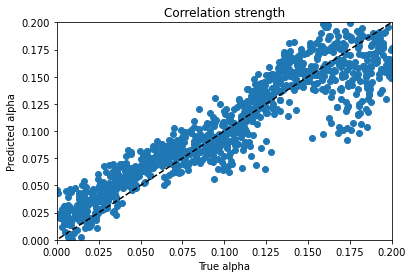

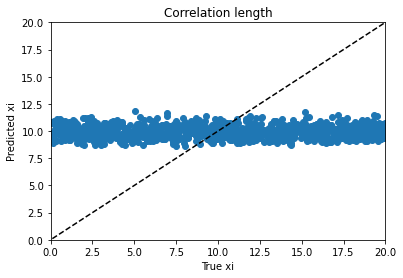

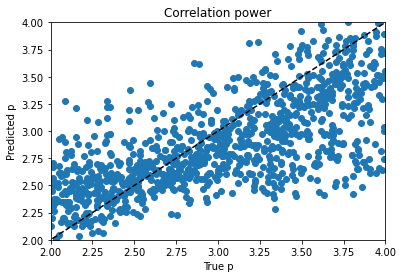

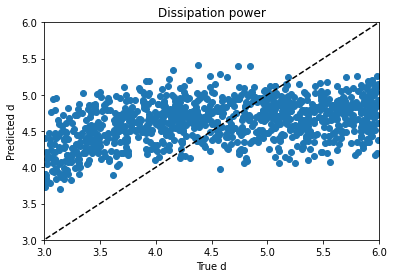

In [50]:
plt.scatter(mat_test[:,0],mat_test_4pred[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat_test_4pred[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat_test_4pred[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat_test_4pred[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Pass 5: Dense with custom loss

In [37]:
input_5node = ak.StructuredDataInput(name='M')
normed_5node = ak.StructuredDataBlock()(input_5node)
dense_5node = ak.DenseBlock()(normed_5node)
#output_5node = ak.RegressionHead(loss=weight_mse,metrics=[weight_mse])(dense_5node)
output_5node = ak.RegressionHead()(dense_5node)

pass5model = ak.AutoModel(inputs=input_5node,outputs=output_5node,
                          overwrite=False,max_trials=20)

INFO:tensorflow:Reloading Oracle from existing project ./auto_model/oracle.json
INFO:tensorflow:Reloading Tuner from ./auto_model/tuner0.json


In [38]:
# Feed the AutoModel with training data.
pass5model.fit(M_train, mat_train, epochs=20)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the bas

In [39]:
# Predict with the best model.
mat_tr_5pred = pass5model.predict(M_train)
mat_test_5pred = pass5model.predict(M_test)

In [48]:
# Evaluate the best model with testing data.
# max_trials=20, epochs=20
print("Training score for pass 5:",weight_mse(mat_train,mat_tr_5pred))
print('Test score for pass 5:',weight_mse(mat_test,mat_test_5pred))

Training score for pass 5: 0.29959950096846444
Test score for pass 5: 0.3034380662160586


In [51]:
k5model = pass5model.export_model()
k5model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                28832     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

## Pass 6: StructuredDataRegressor with custom loss

In [41]:
pass6model = ak.StructuredDataRegressor(overwrite=False,max_trials=20)

INFO:tensorflow:Reloading Oracle from existing project ./structured_data_regressor/oracle.json
INFO:tensorflow:Reloading Tuner from ./structured_data_regressor/tuner0.json


In [42]:
# Feed the AutoModel with training data.
pass6model.fit(M_train, mat_train, epochs=20)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the bas

In [43]:
# Predict with the best model.
mat_tr_6pred = pass6model.predict(M_train)
mat_test_6pred = pass6model.predict(M_test)

In [49]:
# Evaluate the best model with testing data.
print("Training score for pass 6:",weight_mse(mat_train,mat_tr_6pred))
print('Test score for pass 6:',weight_mse(mat_test,mat_test_6pred))

Training score for pass 6: 0.24812649745659826
Test score for pass 6: 0.2621611278858461


In [52]:
k6model = pass6model.export_model()
k6model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 900)               0         
_________________________________________________________________
normalization (Normalization (None, 900)               1801      
_________________________________________________________________
dense (Dense)                (None, 16)                14416     
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
re_lu (ReLU)                 (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)             

## Evaluation and Next Steps

Overcome the custom loss / metric problem, possibly by rerunning the models with no custom items but exploiting the existing model state.

Plot predictions for each network.

Export best model(s) to keras (!!!!!!):
```kmodel = passnmodel.export_model()
model.summary()```

Manual customization based on details from keras summary output.

Tried most of that. Now concerned that models did not save enough of their optimized state under the actual error metric and they drifted off. May need to really drill down far enough to find out how to compose working keras loss and metric structures.